# Experiment Initialization

Here, the terms of the experiment are defined, such as the location of the files in S3 (bucket and folder name), and each of the video prefixes (everything before the file extension) that need to be tracked. 

Note that these videos should be similar-ish: while we can account for differences in mean intensities between videos, particle sizes should be approximately the same, and (slightly less important) particles should be moving at about the same order of magnitude speed. In this experiment, these videos were taken in 0.4% agarose gel at 100x magnification and 100.02 fps shutter speeds with nanoparticles of about 100nm in diameter.

In [1]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 75 #Must be unique number for every run on Cloudknot.

remote_folder = '02_21_20_OGD_Severity_MPT' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
conditions = ['NT', 'OGD_3h']
NT_slices = 2
OGD_3h_slices = 3
NT_regions = ['cortex', 'hippocampus', 'striatum']
OGD_3h_regions = ['cortex', 'striatum']
for cond in conditions:
    if cond == 'NT':
        for slic in range(1,NT_slices+1):
            if slic == 1:
                for reg in NT_regions:
                    if reg == 'cortex':
                        for num in range(1,11):
                            to_track.append('{}_slice_{}_{}_vid_{}'.format(cond, slic, reg, num))
                    elif reg == 'hippocampus':
                        for num in range(1,7):
                            to_track.append('{}_slice_{}_{}_vid_{}'.format(cond, slic, reg, num))
                    else:
                        for num in range(1,vids+1):
                            to_track.append('{}_slice_{}_{}_vid_{}'.format(cond, slic, reg, num))
            else:
                for reg in NT_regions:
                    for num in range(1,vids+1):
                        to_track.append('{}_slice_{}_{}_vid_{}'.format(cond, slic, reg, num))
    else:
        for slic in range(1,OGD_3h_slices+1):
            for reg in OGD_3h_regions:
                for num in range(1,vids+1):
                    to_track.append('{}_slice_{}_{}_vid_{}'.format(cond, slic, reg, num))

In [2]:
to_track

['NT_slice_1_cortex_vid_1',
 'NT_slice_1_cortex_vid_2',
 'NT_slice_1_cortex_vid_3',
 'NT_slice_1_cortex_vid_4',
 'NT_slice_1_cortex_vid_5',
 'NT_slice_1_cortex_vid_6',
 'NT_slice_1_cortex_vid_7',
 'NT_slice_1_cortex_vid_8',
 'NT_slice_1_cortex_vid_9',
 'NT_slice_1_cortex_vid_10',
 'NT_slice_1_hippocampus_vid_1',
 'NT_slice_1_hippocampus_vid_2',
 'NT_slice_1_hippocampus_vid_3',
 'NT_slice_1_hippocampus_vid_4',
 'NT_slice_1_hippocampus_vid_5',
 'NT_slice_1_hippocampus_vid_6',
 'NT_slice_1_striatum_vid_1',
 'NT_slice_1_striatum_vid_2',
 'NT_slice_1_striatum_vid_3',
 'NT_slice_1_striatum_vid_4',
 'NT_slice_1_striatum_vid_5',
 'NT_slice_2_cortex_vid_1',
 'NT_slice_2_cortex_vid_2',
 'NT_slice_2_cortex_vid_3',
 'NT_slice_2_cortex_vid_4',
 'NT_slice_2_cortex_vid_5',
 'NT_slice_2_hippocampus_vid_1',
 'NT_slice_2_hippocampus_vid_2',
 'NT_slice_2_hippocampus_vid_3',
 'NT_slice_2_hippocampus_vid_4',
 'NT_slice_2_hippocampus_vid_5',
 'NT_slice_2_striatum_vid_1',
 'NT_slice_2_striatum_vid_2',
 'NT_s

The videos used with this analysis are fairly large (2048 x 2048 pixels and 651 frames), and in cases like this, the tracking algorithm can quickly eat up RAM. In this case, we chose to crop the videos to 512 x 512 images such that we can run our jobs on smaller EC2 instances with 16GB of RAM. 

Note that larger jobs can be made with user-defined functions such that splitting isn't necessary-- or perhaps an intermediate amount of memory that contains splitting, tracking, and msd calculation functions all performed on a single EC2 instance.

The compiled functions in the knotlets module require access to buckets on AWS. In this case, we will be using a publicly (read-only) bucket. If users want to run this notebook on their own, will have to transfer files from nancelab.publicfiles to their own bucket, as it requires writing to S3 buckets.

In [3]:
import diff_classifier.knotlets as kn

In [ ]:
# This cell uses the function kn.split() to split all of the videos contained in 'to_track' into 16 smaller videos on which the actual tracking will be performed
for prefix in to_track:
    kn.split(prefix, remote_folder=remote_folder, bucket=bucket)

## Tracking predictor

Tracking normally requires user input in the form of tracking parameters e.g. particle radius, linking max distance, max frame gap etc. When large datasets aren't required, each video can be manageably manually tracked using the TrackMate GUI. However, when datasets get large e.g. >20 videos, this can become extremely arduous. For videos that are fairly similar, you can get away with using similar tracking parameters across all videos. However, one parameter that is a little more noisy that the others is the quality filter value. Quality is a numerical value that approximate how likely a particle is to be "real." 

In this case, I built a predictor that estimates the quality filter value based on intensity distributions from the input images. Using a relatively small training dataset (5-20 videos), users can get fairly good estimates of quality filter values that can be used in parallelized tracking workflows.

Note: in the current setup, the predictor should be run in Python 3. While the code will run in Python 3, there are differences between the random number generators in Python2 and Python3 that I was not able to control for.

In [4]:
import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

The regress_sys function should be run twice. When have_output is set to False, it generates a list of files that the user should manually track using Trackmate. Once the quality filter values are found, they can be used as input (y) to generate a regress object that can predict quality filter values for additional videos. Once y is assigned, set have_output to True and re-run the cell.

In [ ]:
tnum=30 #number of training datasets
pref = []
for num in to_track:                    
    for row in range(0, 4):
        for col in range(0, 4):
            pref.append("{}_{}_{}".format(num, row, col))

y = np.array([2.67, 2.11, 4.09, 5.15, 7.75, 4.25, 5.24, 2.75, 3.34, 7.44, 2.13, 1.89, 9.37, 7.07, 3.01, 6.33, 6.42, 6.44, 2.74, 2.85, 26.36, 2.79, 3.59, 5.07, 5.42, 5.95, 6.70, 3.44, 2.27, 4.27])

# Creates regression object based of training dataset composed of input images and manually
# calculated quality cutoffs from tracking with GUI interface.
regress = ij.regress_sys(remote_folder, pref, y, tnum, randselect=True,
                         have_output=True, bucket_name=bucket)
#Read up on how regress_sys works before running.

In [5]:
print(len(to_track))

66


In [ ]:
#Pickle object
filename = 'regress.obj'
with open(filename,'wb') as fp:
    joblib.dump(regress,fp)

import boto3
s3 = boto3.client('s3')
aws.upload_s3(filename, remote_folder+'/'+filename, bucket_name=bucket)

Users should input all tracking parameters into the tparams object. Note that the quality value will be overwritten by values found using the quality predictor found above. Never change threshold, median intensity, or snr

In [5]:
tparams1 = {'radius': 6.0, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 10.0, 'xdims': (0, 511), 'ydims': (1, 511),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 12.0,
           'gap_closing_max_distance': 15.0, 'max_frame_gap': 8.0,
           'track_duration': 10.00}

## Cloudknot is acting up, going to be limited to running tracking one vid at a time in this notebook/EC2 instance.

In [5]:
import diff_classifier.knotlets as kn
import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import numpy as np
from sklearn.externals import joblib

In [6]:
to_track

['NT_slice_1_cortex_vid_1',
 'NT_slice_1_cortex_vid_2',
 'NT_slice_1_cortex_vid_3',
 'NT_slice_1_cortex_vid_4',
 'NT_slice_1_cortex_vid_5',
 'NT_slice_1_cortex_vid_6',
 'NT_slice_1_cortex_vid_7',
 'NT_slice_1_cortex_vid_8',
 'NT_slice_1_cortex_vid_9',
 'NT_slice_1_cortex_vid_10',
 'NT_slice_1_hippocampus_vid_1',
 'NT_slice_1_hippocampus_vid_2',
 'NT_slice_1_hippocampus_vid_3',
 'NT_slice_1_hippocampus_vid_4',
 'NT_slice_1_hippocampus_vid_5',
 'NT_slice_1_hippocampus_vid_6',
 'NT_slice_1_striatum_vid_1',
 'NT_slice_1_striatum_vid_2',
 'NT_slice_1_striatum_vid_3',
 'NT_slice_1_striatum_vid_4',
 'NT_slice_1_striatum_vid_5',
 'NT_slice_2_cortex_vid_1',
 'NT_slice_2_cortex_vid_2',
 'NT_slice_2_cortex_vid_3',
 'NT_slice_2_cortex_vid_4',
 'NT_slice_2_cortex_vid_5',
 'NT_slice_2_hippocampus_vid_1',
 'NT_slice_2_hippocampus_vid_2',
 'NT_slice_2_hippocampus_vid_3',
 'NT_slice_2_hippocampus_vid_4',
 'NT_slice_2_hippocampus_vid_5',
 'NT_slice_2_striatum_vid_1',
 'NT_slice_2_striatum_vid_2',
 'NT_s

In [14]:
to_track[7:9]

['NT_slice_1_cortex_vid_8', 'NT_slice_1_cortex_vid_9']

In [7]:
prefix = [to_track[6],to_track[16],to_track[17], to_track[21], to_track[22], to_track[31], to_track[32], to_track[36],to_track[37], to_track[41],to_track[42], to_track[46],to_track[47], to_track[51],to_track[52],to_track[56],to_track[57], to_track[61],to_track[62],]

In [8]:
prefix

['NT_slice_1_cortex_vid_7',
 'NT_slice_1_striatum_vid_1',
 'NT_slice_1_striatum_vid_2',
 'NT_slice_2_cortex_vid_1',
 'NT_slice_2_cortex_vid_2',
 'NT_slice_2_striatum_vid_1',
 'NT_slice_2_striatum_vid_2',
 'OGD_3h_slice_1_cortex_vid_1',
 'OGD_3h_slice_1_cortex_vid_2',
 'OGD_3h_slice_1_striatum_vid_1',
 'OGD_3h_slice_1_striatum_vid_2',
 'OGD_3h_slice_2_cortex_vid_1',
 'OGD_3h_slice_2_cortex_vid_2',
 'OGD_3h_slice_2_striatum_vid_1',
 'OGD_3h_slice_2_striatum_vid_2',
 'OGD_3h_slice_3_cortex_vid_1',
 'OGD_3h_slice_3_cortex_vid_2',
 'OGD_3h_slice_3_striatum_vid_1',
 'OGD_3h_slice_3_striatum_vid_2']

In [15]:
prefix_2=[to_track[7], to_track[8]]

In [16]:
prefix_2

['NT_slice_1_cortex_vid_8', 'NT_slice_1_cortex_vid_9']

In [20]:
prefix_3=[to_track[18], to_track[19]]

In [21]:
prefix_3

['NT_slice_1_striatum_vid_3', 'NT_slice_1_striatum_vid_4']

In [22]:
remote_folder = '02_21_20_OGD_Severity_MPT'
s3_bucket = 'mckenna.data'

track_list = []
for pref in prefix_3:
    for i in range(0, 4):
        for j in range(0, 4):
            track_list.append(pref+'_{}_{}'.format( i, j))


tparams1={'radius': 6.0, 'threshold': 0.0, 'quality': 2.67, 'do_median_filtering': False,
         'xdims':(0,511), 'ydims':(1,511), 'median_intensity': 300.0,
         'snr':0.0, 'linking_max_distance': 15.0, 'gap_closing_max_distance': 18.0,
         'max_frame_gap': 8, 'track_duration':10.0}

In [23]:
track_list

['NT_slice_1_striatum_vid_3_0_0',
 'NT_slice_1_striatum_vid_3_0_1',
 'NT_slice_1_striatum_vid_3_0_2',
 'NT_slice_1_striatum_vid_3_0_3',
 'NT_slice_1_striatum_vid_3_1_0',
 'NT_slice_1_striatum_vid_3_1_1',
 'NT_slice_1_striatum_vid_3_1_2',
 'NT_slice_1_striatum_vid_3_1_3',
 'NT_slice_1_striatum_vid_3_2_0',
 'NT_slice_1_striatum_vid_3_2_1',
 'NT_slice_1_striatum_vid_3_2_2',
 'NT_slice_1_striatum_vid_3_2_3',
 'NT_slice_1_striatum_vid_3_3_0',
 'NT_slice_1_striatum_vid_3_3_1',
 'NT_slice_1_striatum_vid_3_3_2',
 'NT_slice_1_striatum_vid_3_3_3',
 'NT_slice_1_striatum_vid_4_0_0',
 'NT_slice_1_striatum_vid_4_0_1',
 'NT_slice_1_striatum_vid_4_0_2',
 'NT_slice_1_striatum_vid_4_0_3',
 'NT_slice_1_striatum_vid_4_1_0',
 'NT_slice_1_striatum_vid_4_1_1',
 'NT_slice_1_striatum_vid_4_1_2',
 'NT_slice_1_striatum_vid_4_1_3',
 'NT_slice_1_striatum_vid_4_2_0',
 'NT_slice_1_striatum_vid_4_2_1',
 'NT_slice_1_striatum_vid_4_2_2',
 'NT_slice_1_striatum_vid_4_2_3',
 'NT_slice_1_striatum_vid_4_3_0',
 'NT_slice_1_s

In [24]:
for vid in track_list:
    kn.tracking(vid, remote_folder, bucket=s3_bucket, regress_f='regress.obj', rows=4, cols=4, ires=(512,512),
            tparams=tparams1)
    os.remove(vid+'.tif')
    os.remove('Traj_'+vid+'.csv')

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpdrwggt8g.py
Done with tracking.  Should output file of name 02_21_20_OGD_Severity_MPT/Traj_NT_slice_1_striatum_vid_3_0_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmprc7a3u97.py
Done with tracking.  Should output file of name 02_21_20_OGD_Severity_MPT/Traj_NT_slice_1_striatum_vid_3_0_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpltdko388.py
Done with tracking.  Should output file of name 02_21_20_OGD_Severity_MPT/Traj_NT_slice_1_striatum_vid_3_0_2.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpfxgqgth3.py
Done with tracking.  Should output file of name 02_21_20_OGD_Severity_MPT/Traj_NT_slice_1_striatum_vid_3_0_3.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmprvyrygi0.py
Done with tracking.  Should output file of name 02_21_20_OGD_Severity_MPT/Traj_NT_slice_1_striatum_vid_3_1_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux6

In [25]:
to_track

['NT_slice_1_cortex_vid_1',
 'NT_slice_1_cortex_vid_2',
 'NT_slice_1_cortex_vid_3',
 'NT_slice_1_cortex_vid_4',
 'NT_slice_1_cortex_vid_5',
 'NT_slice_1_cortex_vid_6',
 'NT_slice_1_cortex_vid_7',
 'NT_slice_1_cortex_vid_8',
 'NT_slice_1_cortex_vid_9',
 'NT_slice_1_cortex_vid_10',
 'NT_slice_1_hippocampus_vid_1',
 'NT_slice_1_hippocampus_vid_2',
 'NT_slice_1_hippocampus_vid_3',
 'NT_slice_1_hippocampus_vid_4',
 'NT_slice_1_hippocampus_vid_5',
 'NT_slice_1_hippocampus_vid_6',
 'NT_slice_1_striatum_vid_1',
 'NT_slice_1_striatum_vid_2',
 'NT_slice_1_striatum_vid_3',
 'NT_slice_1_striatum_vid_4',
 'NT_slice_1_striatum_vid_5',
 'NT_slice_2_cortex_vid_1',
 'NT_slice_2_cortex_vid_2',
 'NT_slice_2_cortex_vid_3',
 'NT_slice_2_cortex_vid_4',
 'NT_slice_2_cortex_vid_5',
 'NT_slice_2_hippocampus_vid_1',
 'NT_slice_2_hippocampus_vid_2',
 'NT_slice_2_hippocampus_vid_3',
 'NT_slice_2_hippocampus_vid_4',
 'NT_slice_2_hippocampus_vid_5',
 'NT_slice_2_striatum_vid_1',
 'NT_slice_2_striatum_vid_2',
 'NT_s

In [26]:
msd_list = [to_track[5], to_track[6], to_track[7], to_track[8],
           to_track[16], to_track[17], to_track[18], to_track[19],
           to_track[21], to_track[22], to_track[31], to_track[32],
           to_track[36], to_track[37], to_track[41], to_track[42],
           to_track[46], to_track[47], to_track[51], to_track[52],
           to_track[56], to_track[57], to_track[61], to_track[62]]

In [27]:
msd_list

['NT_slice_1_cortex_vid_6',
 'NT_slice_1_cortex_vid_7',
 'NT_slice_1_cortex_vid_8',
 'NT_slice_1_cortex_vid_9',
 'NT_slice_1_striatum_vid_1',
 'NT_slice_1_striatum_vid_2',
 'NT_slice_1_striatum_vid_3',
 'NT_slice_1_striatum_vid_4',
 'NT_slice_2_cortex_vid_1',
 'NT_slice_2_cortex_vid_2',
 'NT_slice_2_striatum_vid_1',
 'NT_slice_2_striatum_vid_2',
 'OGD_3h_slice_1_cortex_vid_1',
 'OGD_3h_slice_1_cortex_vid_2',
 'OGD_3h_slice_1_striatum_vid_1',
 'OGD_3h_slice_1_striatum_vid_2',
 'OGD_3h_slice_2_cortex_vid_1',
 'OGD_3h_slice_2_cortex_vid_2',
 'OGD_3h_slice_2_striatum_vid_1',
 'OGD_3h_slice_2_striatum_vid_2',
 'OGD_3h_slice_3_cortex_vid_1',
 'OGD_3h_slice_3_cortex_vid_2',
 'OGD_3h_slice_3_striatum_vid_1',
 'OGD_3h_slice_3_striatum_vid_2']

In [28]:
for ea in msd_list:
    kn.assemble_msds(ea, remote_folder, bucket=s3_bucket)
    print('Successfully output msds for {}'.format(prefix))

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:313: RuntimeWarning: invalid value encountered in double_scalars
  asym1 = (eig1**2 - eig2**2)**2/(eig1**2 + eig2**2)**2
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:314: RuntimeWarning: invalid value encountered in double_scalars
  asym2 = eig2/eig1
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:315: RuntimeWarning: invalid value encountered in double_scalars
  asym3 = -np.log(1-((eig1-eig2)**2)/(2*(eig1+eig2)**2))
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: invalid value encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:602: RuntimeWarning: invalid value encountered in double_scalars
  bound = dcoef*fram/(rad**2)
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:603: RuntimeWarning: invalid value encountered in double_scalars
  fractd = np.log(N)/np.log(N*2*rad/n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:313: RuntimeWarning: invalid value encountered in double_scalars
  asym1 = (eig1**2 - eig2**2)**2/(eig1**2 + eig2**2)**2
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:314: RuntimeWarning: invalid value encountered in double_scalars
  asym2 = eig2/eig1
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:315: RuntimeWarning: invalid value encountered in double_scalars
  asym3 = -np.log(1-((eig1-eig2)**2)/(2*(eig1+eig2)**2))
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: invalid value encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:602: RuntimeWarning: invalid value encountered in double_scalars
  bound = dcoef*fram/(rad**2)
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:603: RuntimeWarning: invalid value encountered in double_scalars
  fractd = np.log(N)/np.log(N*2*rad/n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:313: RuntimeWarning: invalid value encountered in double_scalars
  asym1 = (eig1**2 - eig2**2)**2/(eig1**2 + eig2**2)**2
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:314: RuntimeWarning: invalid value encountered in double_scalars
  asym2 = eig2/eig1
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:315: RuntimeWarning: invalid value encountered in double_scalars
  asym3 = -np.log(1-((eig1-eig2)**2)/(2*(eig1+eig2)**2))
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: invalid value encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:602: RuntimeWarning: invalid value encountered in double_scalars
  bound = dcoef*fram/(rad**2)
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:603: RuntimeWarning: invalid value encountered in double_scalars
  fractd = np.log(N)/np.log(N*2*rad/n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid_2', 'OGD_3h_slice_2_striatum_vid_1', 'OGD_3h_slice_2_striatum_vid_2', 'OGD_3h_slice_3_cortex_vid_

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:313: RuntimeWarning: invalid value encountered in double_scalars
  asym1 = (eig1**2 - eig2**2)**2/(eig1**2 + eig2**2)**2
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:314: RuntimeWarning: invalid value encountered in double_scalars
  asym2 = eig2/eig1
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:315: RuntimeWarning: invalid value encountered in double_scalars
  asym3 = -np.log(1-((eig1-eig2)**2)/(2*(eig1+eig2)**2))
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: invalid value encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:602: RuntimeWarning: invalid value encountered in double_scalars
  bound = dcoef*fram/(rad**2)
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:603: RuntimeWarning: invalid value encountered in double_scalars
  fractd = np.log(N)/np.log(N*2*rad/n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid_2', 'OGD_3h_slice_2_striatum_vid_1', 'OGD_3h_slice_2_striatum_vid_2', 'OGD_3h_slice_3_cortex_vid_1', 'OGD_3h_slice_3_cortex_vid_2', 'OGD_3h_slice_

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid_2', 'OGD_3h_slice_2_striatum_vid_1', 'OGD_3h_slice_2_striatum_vid_2', 'OGD_3h_slice_3_cortex_vid_

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Successfully output msds for ['NT_slice_1_cortex_vid_7', 'NT_slice_1_striatum_vid_1', 'NT_slice_1_striatum_vid_2', 'NT_slice_2_cortex_vid_1', 'NT_slice_2_cortex_vid_2', 'NT_slice_2_striatum_vid_1', 'NT_slice_2_striatum_vid_2', 'OGD_3h_slice_1_cortex_vid_1', 'OGD_3h_slice_1_cortex_vid_2', 'OGD_3h_slice_1_striatum_vid_1', 'OGD_3h_slice_1_striatum_vid_2', 'OGD_3h_slice_2_cortex_vid_1', 'OGD_3h_slice_2_cortex_vid_2', 'OGD_3h_slice_2_striatum_vid_1', 'OGD_3h_slice_2_striatum_vid_2', 'OGD_3h_slice_3_cortex_vid_1', 'OGD_3h_slice_3_cortex_vid_2', 'OGD_3h_slice_3_striatum_vid_1', 'OGD_3h_slice_3_striatum_vid_2']
Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

## Downstream analysis and visualization

The knotlet.assemble_msds function (which can also potentially be submitted to Cloudknot as well for large jobs) calculates the mean squared displacements and trajectory features from the raw trajectory csv files found from the Cloudknot submission. It accesses them from the S3 bucket to which they were saved.

In [ ]:
for prefix in to_track:
    kn.assemble_msds(prefix, remote_folder, bucket='mckenna.data')
    print('Successfully output msds for {}'.format(prefix))

In [ ]:
for prefix in to_track[5:7]:
    kn.assemble_msds(prefix, remote_folder, bucket='ccurtis.data')
    print('Successfully output msds for {}'.format(prefix))

Diff_classifier includes some useful imaging tools as well, including checking trajectories, plotting heatmaps of trajectory features, distributions of diffusion coefficients, and MSD plots.

In [36]:
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws
import os
import os.path as op

In [ ]:
to_track

In [37]:
remote_folder = '02_21_20_OGD_Severity_MPT'
s3_bucket = 'mckenna.data'

Plotted NT_slice_1_cortex_vid_6 trajectories successfully.
Successfully uploaded trajectory plot for NT_slice_1_cortex_vid_6
Successfully uploaded csv files for NT_slice_1_cortex_vid_6


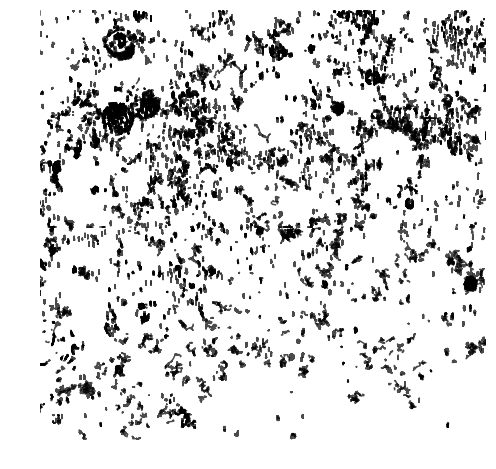

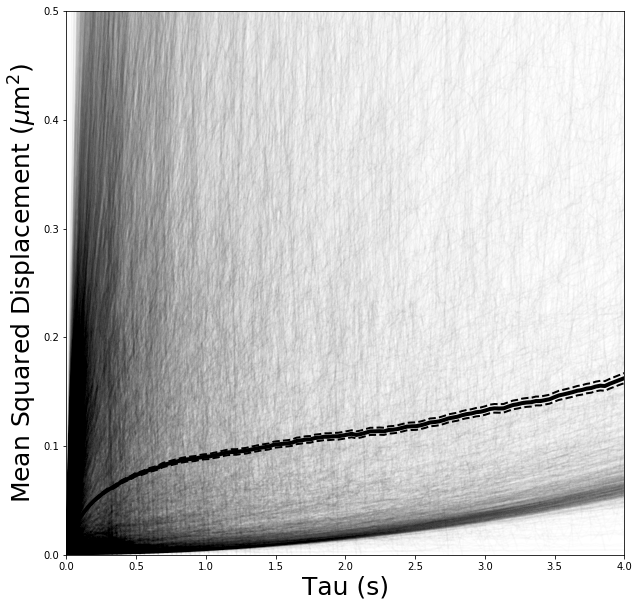

In [39]:
prefix = to_track[5]
msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)
print('Successfully uploaded trajectory plot for {}'.format(prefix))
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=30.3, upload=True, remote_folder=remote_folder, bucket = s3_bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)
os.remove('features_{}.csv'.format(prefix))
os.remove('geoSEM_{}.csv'.format(prefix))
os.remove('msd_{}.csv'.format(prefix))
os.remove('geomean_{}.csv'.format(prefix))
os.remove('msds_{}.png'.format(prefix))
print('Successfully uploaded csv files for {}'.format(prefix))


In [38]:
for vids in to_track[5]:
    prefix = vids
    msds = 'msd_{}.csv'.format(prefix)
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)
    hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)
    print('Successfully uploaded trajectory plot for {}'.format(prefix))
    geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=30.3, upload=True, remote_folder=remote_folder, bucket = s3_bucket)
    aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
    aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
    aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)
    os.remove('features_{}.csv'.format(prefix))
    os.remove('geoSEM_{}.csv'.format(prefix))
    os.remove('msd_{}.csv'.format(prefix))
    os.remove('geomean_{}.csv'.format(prefix))
    os.remove('msds_{}.png'.format(prefix))
    print('Successfully uploaded csv files for {}'.format(prefix))
    
    

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=100, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

In [ ]:
hm.plot_heatmap(prefix, upload=False)

In [ ]:
hm.plot_particles_in_frame(prefix, y_range=500, upload=False)

In [ ]:
prefix = to_track[0]

msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
aws.download_s3('{}/{}'.format(remote_folder, msds), msds, bucket_name=bucket)
aws.download_s3('{}/{}'.format(remote_folder, feat), feat, bucket_name=bucket)

In [ ]:
hm.plot_trajectories(prefix, remote_folder=remote_folder, upload=True, figsize=(8, 8), bucket = bucket)

In [ ]:
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=0.5, umppx=0.07, fps=100, upload=True, remote_folder=remote_folder, bucket = bucket)
aws.upload_s3('./geomean_{}.csv'.format(prefix), remote_folder+'/geomean_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./geoSEM_{}.csv'.format(prefix), remote_folder+'/geoSEM_{}.csv'.format(prefix), bucket_name = bucket)
aws.upload_s3('./msds_{}.png'.format(prefix), remote_folder+'/msds_{}.png'.format(prefix), bucket_name = bucket)

## Converting msd files

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir

In [ ]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '08_06_19_MPT_age_dependence' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_sizes = ['40','100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
ages = ['P14', 'P21', 'P28']
slices = 3
for size in NP_sizes:
    for age in ages:
        for slic in range(1, slices+1):
            for num in range(1, vids+1):
                to_track.append('{}_{}nm_s{}_v{}'.format(age, size, slic, num))

In [ ]:
to_track

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math

for prefix in to_track[45:90]:
    filename = 'geomean_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
    local_name = filename
    merged = pd.read_csv(local_name)
    merged.columns = ['log']
    merged['exp'] = 0
    for rows in range(0,len(merged)):
        log_value = merged['log'].iloc[rows]
        exp_value = math.exp(log_value)
        merged.loc[rows,'exp'] = exp_value
    merged.to_csv('adj_'+filename, mode='w', index = False)
    aws.upload_s3('./adj_'+filename, remote_folder+'/adj_'+filename, bucket_name = bucket)
    os.remove(filename)
    os.remove('adj_'+filename)

In [ ]:
pref = 'adj_geomean_'

mol_wts = ['high', 'low', 'med']
num_vids = 5

for MW in mol_wts:
    avg_df = pd.DataFrame()
    for vid in range(1, num_vids+1):
        exp = pd.read_csv(pref+'{}MW_40nm_vid_{}.csv'.format(MW, str(vid)))
        avg_df = pd.concat([avg_df, exp['exp']], axis=1)
    avg_df = avg_df.mean(axis = 1)
    avg_df.to_csv('avg_'+pref+'{}MW_40nm.csv'.format(MW), mode='w', index = False)
    aws.upload_s3('./avg_'+pref+'{}MW_40nm.csv'.format(MW), remote_folder+'/avg_'+pref+'{}MW_40nm.csv'.format(MW), bucket_name=bucket)
    

## Generating Histograms

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir

In [ ]:
to_track

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math

high_track = to_track[0:5]
low_track = to_track[5:10]
med_track = to_track[10:15]

low_MW = pd.DataFrame()
med_MW = pd.DataFrame()
high_MW = pd.DataFrame()

um_px = 0.07
fps = 33

for prefix in low_track:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, 'trial_2_'+feat, bucket_name=bucket)
    merged = pd.read_csv('trial_2_'+feat)
    low_MW = pd.concat([low_MW, merged['Deff1']*um_px*um_px*fps/10], axis=0)
    
for prefix in med_track:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, 'trial_2_'+feat, bucket_name=bucket)
    merged = pd.read_csv('trial_2_'+feat)
    med_MW = pd.concat([med_MW, merged['Deff1']*um_px*um_px*fps/10], axis=0)
    
for prefix in high_track:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, 'trial_2_'+feat, bucket_name=bucket)
    merged = pd.read_csv('trial_2_'+feat)
    high_MW = pd.concat([high_MW, merged['Deff1']*um_px*um_px*fps/10], axis=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

low_no_nan = low_MW.replace(0,np.nan)
med_no_nan = med_MW.replace(0,np.nan)
high_no_nan = high_MW.replace(0,np.nan)


log_Deff_low = np.log(low_no_nan[0].dropna())
#print(log_Deff_low)
log_Deff_med = np.log(med_no_nan[0].dropna())
#print(log_Deff_low)
log_Deff_high = np.log(high_no_nan[0].dropna())

test_bins = np.linspace(-12, 0, 76)

low_hist, low_bins = np.histogram(log_Deff_low, bins=test_bins)
med_hist, med_bins = np.histogram(log_Deff_med, bins=test_bins)
high_hist, high_bins = np.histogram(log_Deff_high, bins=test_bins)

low_avg = np.mean(log_Deff_low)
med_avg = np.mean(log_Deff_med)
high_avg = np.mean(log_Deff_high)

plt.rc('axes', linewidth=2)
low_plot, med_plot, high_plot = low_hist, med_hist, high_hist
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, high_plot, color='royalblue', align='center', width=width, alpha=0.6, label='high MW')
plt.axvline(high_avg, color='royalblue', linestyle='--', linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, med_plot, color='darkgreen', align='center', width=width, alpha=0.7, label='medium MW')
plt.axvline(med_avg, color='darkgreen', linestyle='--', linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, low_plot, color='firebrick', align='center', width=width, alpha=1, label='low MW')
plt.axvline(low_avg, color='firebrick', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,600))
plt.legend(fontsize='large', loc=2)
plt.show()

In [ ]:
print(low_avg, med_avg, high_avg)
print(np.exp(low_avg), np.exp(med_avg), np.exp(high_avg))

## Combined HA Solution Histograms

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir
from scipy import stats

In [ ]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '08_06_19_MPT_age_dependence' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_sizes = ['40','100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
ages = ['P14', 'P21', 'P28']
slices = 3
for size in NP_sizes:
    for age in ages:
        for slic in range(1, slices+1):
            for num in range(1, vids+1):
                to_track.append('{}_{}nm_s{}_v{}'.format(age, size, slic, num))

In [ ]:
print(len(to_track))
to_track

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math

P14_track_40 = to_track[0:15]
P21_track_40 = to_track[15:30]
P28_track_40 = to_track[30:45]
P14_track_100 = to_track[45:60]
P21_track_100 = to_track[60:75]
P28_track_100 = to_track[75:90]

P14_40 = pd.DataFrame()
P21_40 = pd.DataFrame()
P28_40 = pd.DataFrame()
P14_100 = pd.DataFrame()
P21_100 = pd.DataFrame()
P28_100 = pd.DataFrame()

um_px = 0.07
fps_40 = 33
fps_100 = 100

for prefix in P14_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P14_40 = pd.concat([P14_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
P14_40.to_csv('P14_40nm.csv', mode='w', index = False)
    
for prefix in P21_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P21_40 = pd.concat([P21_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
P21_40.to_csv('P21_40nm.csv', mode='w', index = False)
    
for prefix in P28_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P28_40 = pd.concat([P28_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
P28_40.to_csv('P28_40nm.csv', mode='w', index = False)    
    
for prefix in P14_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P14_100 = pd.concat([P14_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
P14_100.to_csv('P14_100nm.csv', mode='w', index = False)
    
for prefix in P21_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P21_100 = pd.concat([P21_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
P21_100.to_csv('P21_100nm.csv', mode='w', index = False)
    
for prefix in P28_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    P28_100 = pd.concat([P28_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
P28_100.to_csv('P28_100nm.csv', mode='w', index = False)

In [ ]:
to_track = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder = '07_10_19_MPT_HA_solutions_trial2' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained
NP_sizes = ['40', '100']
vids = 5 # this is the number of vids that were taken per condition (usually corresponding to different locations)
mol_weights = ['high', 'low', 'med']

for MW in mol_weights:
    for size in NP_sizes:
        for num in range(1, vids+1):
            to_track.append('{}MW_{}nm_vid_{}'.format(MW, size, num))
            


In [ ]:
print(len(to_track))
to_track

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math

high_track_40 = to_track[0:5]
low_track_40 = to_track[10:15]
med_track_40 = to_track[20:25]
high_track_100 = to_track[5:10]
low_track_100 = to_track[15:20]
med_track_100 = to_track[25:30]


low_MW_40 = pd.DataFrame()
med_MW_40 = pd.DataFrame()
high_MW_40 = pd.DataFrame()
low_MW_100 = pd.DataFrame()
med_MW_100 = pd.DataFrame()
high_MW_100 = pd.DataFrame()

um_px = 0.07
fps_40 = 33
fps_100 = 100

for prefix in low_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    low_MW_40 = pd.concat([low_MW_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
low_MW_40.to_csv('40nm_lowMW_trial_2.csv', mode='w', index = False)
    
for prefix in med_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    med_MW_40 = pd.concat([med_MW_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
med_MW_40.to_csv('40nm_medMW_trial_2.csv', mode='w', index = False)
    
for prefix in high_track_40:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    high_MW_40 = pd.concat([high_MW_40, merged['Deff1']*um_px*um_px*fps_40/10], axis=0)
    os.remove(feat)
high_MW_40.to_csv('40nm_highMW_trial_2.csv', mode='w', index = False)    
    
for prefix in low_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    low_MW_100 = pd.concat([low_MW_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
low_MW_100.to_csv('100nm_lowMW_trial_2.csv', mode='w', index = False)
    
for prefix in med_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    med_MW_100 = pd.concat([med_MW_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
med_MW_100.to_csv('100nm_medMW_trial_2.csv', mode='w', index = False)
    
for prefix in high_track_100:
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    high_MW_100 = pd.concat([high_MW_100, merged['Deff1']*um_px*um_px*fps_100/10], axis=0)
    os.remove(feat)
high_MW_100.to_csv('100nm_highMW_trial_2.csv', mode='w', index = False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_40nm = pd.read_csv('P14_40nm.csv')
P21_40nm = pd.read_csv('P21_40nm.csv')
P28_40nm = pd.read_csv('P28_40nm.csv')
NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

P35_40nm = pd.DataFrame()
P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_40_no_nan = P14_40nm.replace(0,np.nan)
P21_40_no_nan = P21_40nm.replace(0,np.nan)
P28_40_no_nan = P28_40nm.replace(0,np.nan)
P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_40 = np.log(P14_40_no_nan.dropna())
log_Deff_P21_40 = np.log(P21_40_no_nan.dropna())
log_Deff_P28_40 = np.log(P28_40_no_nan.dropna())
log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-10, 2, 76)

P14_hist_40, P14_bins_40 = np.histogram(log_Deff_P14_40, bins=test_bins)
P21_hist_40, P21_bins_40 = np.histogram(log_Deff_P21_40, bins=test_bins)
P28_hist_40, P28_bins_40 = np.histogram(log_Deff_P28_40, bins=test_bins)
P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_40 = np.mean(log_Deff_P14_40)[0]
P21_avg_40 = np.mean(log_Deff_P21_40)[0]
P28_avg_40 = np.mean(log_Deff_P28_40)[0]
P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_40, P21_plot_40, P28_plot_40, P35_plot_40 = P14_hist_40, P21_hist_40, P28_hist_40, P35_hist_40
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P14_plot_40, color='grey', align='center', width=width, alpha=0.8, label='P14')
plt.axvline(P14_avg_40, color='grey', linestyle='--', linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P21_plot_40, color='goldenrod', align='center', width=width, alpha=0.7, label='P21')
plt.axvline(P21_avg_40, color='goldenrod', linestyle='--', linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P28_plot_40, color='royalblue', align='center', width=width, alpha=0.7, label='P28')
plt.axvline(P28_avg_40, color='royalblue', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P35_plot_40, color='purple', align='center', width=width, alpha=0.7, label='P35')
plt.axvline(P35_avg_40, color='purple', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,1400))
plt.legend(fontsize='x-large', loc=2)
plt.show()

## Statistics

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math
import os
import os.path as op
from os import listdir
import numpy as np

In [ ]:
to_track[0:45]

In [ ]:
remote_folder

In [ ]:

um_px = 0.07
fps = 33

for prefix in to_track[0:45]:
    temp = pd.DataFrame()
    feat = 'features_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+feat, feat, bucket_name=bucket)
    merged = pd.read_csv(feat)
    temp = pd.concat([temp, merged['Deff1']*um_px*um_px/(1/fps*10)], axis=0)
    temp_no_nan = temp.replace(0,np.nan)
    temp_upload = temp_no_nan.dropna()
    temp_upload.to_csv('{}_stats.csv'.format(prefix), mode='w', index = False)
    aws.upload_s3('{}_stats.csv'.format(prefix), '07_16_19_ECM_Breakdown/{}_stats.csv'.format(prefix), bucket_name='mckenna.data')
    os.remove(feat)
    os.remove('{}_stats.csv'.format(prefix))

In [ ]:
print(P14_avg_40, P21_avg_40, P28_avg_40, P35_avg_40)
print(np.exp(P14_avg_40), np.exp(P21_avg_40), np.exp(P28_avg_40), np.exp(P35_avg_40))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_40nm = pd.read_csv('P14_40nm.csv')
P21_40nm = pd.read_csv('P21_40nm.csv')
P28_40nm = pd.read_csv('P28_40nm.csv')
NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

P35_40nm = pd.DataFrame()
P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_40_no_nan = P14_40nm.replace(0,np.nan)
P21_40_no_nan = P21_40nm.replace(0,np.nan)
P28_40_no_nan = P28_40nm.replace(0,np.nan)
P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_40 = np.log(P14_40_no_nan.dropna())
log_Deff_P21_40 = np.log(P21_40_no_nan.dropna())
log_Deff_P28_40 = np.log(P28_40_no_nan.dropna())
log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-10, 2, 76)

P14_hist_40, P14_bins_40 = np.histogram(log_Deff_P14_40, bins=test_bins)
P21_hist_40, P21_bins_40 = np.histogram(log_Deff_P21_40, bins=test_bins)
P28_hist_40, P28_bins_40 = np.histogram(log_Deff_P28_40, bins=test_bins)
P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_40 = np.mean(log_Deff_P14_40)[0]
P21_avg_40 = np.mean(log_Deff_P21_40)[0]
P28_avg_40 = np.mean(log_Deff_P28_40)[0]
P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_40, P21_plot_40, P28_plot_40, P35_plot_40 = P14_hist_40, P21_hist_40, P28_hist_40, P35_hist_40
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P21_plot_40, color='goldenrod', align='center', width=width, alpha=0.7, label='P21')
plt.axvline(P21_avg_40, color='goldenrod', linestyle='--', linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,1400))
plt.legend(fontsize='x-large', loc=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_40nm = pd.read_csv('P14_40nm.csv')
P21_40nm = pd.read_csv('P21_40nm.csv')
P28_40nm = pd.read_csv('P28_40nm.csv')
NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

P35_40nm = pd.DataFrame()
P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_40_no_nan = P14_40nm.replace(0,np.nan)
P21_40_no_nan = P21_40nm.replace(0,np.nan)
P28_40_no_nan = P28_40nm.replace(0,np.nan)
P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_40 = np.log(P14_40_no_nan.dropna())
log_Deff_P21_40 = np.log(P21_40_no_nan.dropna())
log_Deff_P28_40 = np.log(P28_40_no_nan.dropna())
log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-10, 2, 76)

P14_hist_40, P14_bins_40 = np.histogram(log_Deff_P14_40, bins=test_bins)
P21_hist_40, P21_bins_40 = np.histogram(log_Deff_P21_40, bins=test_bins)
P28_hist_40, P28_bins_40 = np.histogram(log_Deff_P28_40, bins=test_bins)
P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_40 = np.mean(log_Deff_P14_40)[0]
P21_avg_40 = np.mean(log_Deff_P21_40)[0]
P28_avg_40 = np.mean(log_Deff_P28_40)[0]
P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_40, P21_plot_40, P28_plot_40, P35_plot_40 = P14_hist_40, P21_hist_40, P28_hist_40, P35_hist_40
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P35_plot_40, color='purple', align='center', width=width, alpha=0.7, label='P35')
plt.axvline(P35_avg_40, color='purple', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,1400))
plt.legend(fontsize='x-large', loc=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_40nm = pd.read_csv('P14_40nm.csv')
P21_40nm = pd.read_csv('P21_40nm.csv')
P28_40nm = pd.read_csv('P28_40nm.csv')
NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

P35_40nm = pd.DataFrame()
P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_40_no_nan = P14_40nm.replace(0,np.nan)
P21_40_no_nan = P21_40nm.replace(0,np.nan)
P28_40_no_nan = P28_40nm.replace(0,np.nan)
P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_40 = np.log(P14_40_no_nan.dropna())
log_Deff_P21_40 = np.log(P21_40_no_nan.dropna())
log_Deff_P28_40 = np.log(P28_40_no_nan.dropna())
log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-10, 2, 76)

P14_hist_40, P14_bins_40 = np.histogram(log_Deff_P14_40, bins=test_bins)
P21_hist_40, P21_bins_40 = np.histogram(log_Deff_P21_40, bins=test_bins)
P28_hist_40, P28_bins_40 = np.histogram(log_Deff_P28_40, bins=test_bins)
P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_40 = np.mean(log_Deff_P14_40)[0]
P21_avg_40 = np.mean(log_Deff_P21_40)[0]
P28_avg_40 = np.mean(log_Deff_P28_40)[0]
P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_40, P21_plot_40, P28_plot_40, P35_plot_40 = P14_hist_40, P21_hist_40, P28_hist_40, P35_hist_40
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P14_plot_40, color='grey', align='center', width=width, alpha=0.8, label='P14')
plt.axvline(P14_avg_40, color='grey', linestyle='--', linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,1400))
plt.legend(fontsize='x-large', loc=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_40nm = pd.read_csv('P14_40nm.csv')
P21_40nm = pd.read_csv('P21_40nm.csv')
P28_40nm = pd.read_csv('P28_40nm.csv')
NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

P35_40nm = pd.DataFrame()
P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_40_no_nan = P14_40nm.replace(0,np.nan)
P21_40_no_nan = P21_40nm.replace(0,np.nan)
P28_40_no_nan = P28_40nm.replace(0,np.nan)
P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_40 = np.log(P14_40_no_nan.dropna())
log_Deff_P21_40 = np.log(P21_40_no_nan.dropna())
log_Deff_P28_40 = np.log(P28_40_no_nan.dropna())
log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-10, 2, 76)

P14_hist_40, P14_bins_40 = np.histogram(log_Deff_P14_40, bins=test_bins)
P21_hist_40, P21_bins_40 = np.histogram(log_Deff_P21_40, bins=test_bins)
P28_hist_40, P28_bins_40 = np.histogram(log_Deff_P28_40, bins=test_bins)
P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_40 = np.mean(log_Deff_P14_40)[0]
P21_avg_40 = np.mean(log_Deff_P21_40)[0]
P28_avg_40 = np.mean(log_Deff_P28_40)[0]
P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_40, P21_plot_40, P28_plot_40, P35_plot_40 = P14_hist_40, P21_hist_40, P28_hist_40, P35_hist_40
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P28_plot_40, color='royalblue', align='center', width=width, alpha=0.7, label='P28')
plt.axvline(P28_avg_40, color='royalblue', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,1400))
plt.legend(fontsize='x-large', loc=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

P14_100nm = pd.read_csv('P14_100nm.csv')
P21_100nm = pd.read_csv('P21_100nm.csv')
P28_100nm = pd.read_csv('P28_100nm.csv')
#NT_brain_2 = pd.read_csv('NT_brain_2_hist.csv')

#P35_40nm = pd.DataFrame()
#P35_40nm = pd.concat([NT_brain_2], axis=0)

P14_100_no_nan = P14_100nm.replace(0,np.nan)
P21_100_no_nan = P21_100nm.replace(0,np.nan)
P28_100_no_nan = P28_100nm.replace(0,np.nan)
#P35_40_no_nan = P35_40nm.replace(0,np.nan)

log_Deff_P14_100 = np.log(P14_100_no_nan.dropna())
log_Deff_P21_100 = np.log(P21_100_no_nan.dropna())
log_Deff_P28_100 = np.log(P28_100_no_nan.dropna())
#log_Deff_P35_40 = np.log(P35_40_no_nan.dropna())

test_bins = np.linspace(-5, 1, 76)

P14_hist_100, P14_bins_100 = np.histogram(log_Deff_P14_100, bins=test_bins)
P21_hist_100, P21_bins_100 = np.histogram(log_Deff_P21_100, bins=test_bins)
P28_hist_100, P28_bins_100 = np.histogram(log_Deff_P28_100, bins=test_bins)
#P35_hist_40, P35_bins_40 = np.histogram(log_Deff_P35_40, bins=test_bins)

P14_avg_100 = np.mean(log_Deff_P14_100)[0]
P21_avg_100 = np.mean(log_Deff_P21_100)[0]
P28_avg_100 = np.mean(log_Deff_P28_100)[0]
#P35_avg_40 = np.mean(log_Deff_P35_40)[0]

plt.rc('axes', linewidth=2)
P14_plot_100, P21_plot_100, P28_plot_100 = P14_hist_100, P21_hist_100, P28_hist_100
bins = test_bins
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:])/2

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P14_plot_100, color='royalblue', align='center', width=width, alpha=0.8, label='P14')
plt.axvline(P14_avg_100, color='royalblue', linestyle='--', linewidth=3)
plt.ylim((0,800))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P21_plot_100, color='darkgreen', align='center', width=width, alpha=0.9, label='P21')
plt.axvline(P21_avg_100, color='darkgreen', linestyle='--', linewidth=3)
plt.ylim((0,400))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.figure(1, figsize=(7,4)).tight_layout()
plt.bar(center, P28_plot_100, color='firebrick', align='center', width=width, alpha=0.7, label='P28')
plt.axvline(P28_avg_100, color='firebrick', linestyle='--', linewidth=3)
plt.ylim((0,100))
plt.xlabel('log $D_{eff}$', fontsize=20)
plt.ylabel('Trajectory Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.ylim((0,2000))
plt.legend()
plt.show()

In [ ]:
print(P14_avg_100, P21_avg_100, P28_avg_100)
print(np.exp(P14_avg_100), np.exp(P21_avg_100), np.exp(P28_avg_100))

## MSD plots

In [ ]:
import pandas as pd
import diff_classifier.aws as aws
import math
import numpy as np

In [ ]:
for prefix in to_track[0:45]:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)

In [ ]:
for prefix in to_track[0:45]:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    os.remove(filename)

In [ ]:
# This is importing P35 dataset

to_track_P35 = [] # This is going to be the list of all filenames that will be included in the analysis
start_knot = 80 #Must be unique number for every run on Cloudknot.

remote_folder_P35 = '07_16_19_MPT_ECM_breakdown' # The folder in AWS S3 containing the files to be analyzed
bucket = 'mckenna.data' # The bucket in AWS S3 where the remote_folder is contained

treatments = ['NT']
brains = 4
slices = 3
vids = 5

for treat in treatments:
    for brain in range(1, brains+1):
        for slic in range(1, slices+1):
            for num in range(1, vids+1):
                to_track_P35.append('{}_brain_{}_slice_{}_vid_{}'.format(treat, brain, slic, num))

In [ ]:
to_track_P35

In [ ]:
import matplotlib.pyplot as plt

P14_MSDs = pd.DataFrame()
P21_MSDs = pd.DataFrame()
P28_MSDs = pd.DataFrame()
P35_MSDs = pd.DataFrame()

P14_plot_array = []
P21_plot_array = []
P28_plot_array = []
P35_plot_array = []

P14_MSDs['time'] = pd.Series(np.linspace(1/33, 1/33*650, 650))
P21_MSDs['time'] = pd.Series(np.linspace(1/33, 1/33*650, 650))
P28_MSDs['time'] = pd.Series(np.linspace(1/33, 1/33*650, 650))
P35_MSDs['time'] = pd.Series(np.linspace(1/33, 1/33*650, 650))

for prefix in to_track[0:15]:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    P14_MSDs = pd.concat([P14_MSDs, pd.read_csv(filename)['exp']], axis = 1)
    P14_MSDs.rename(columns={"exp": prefix}, inplace=True)
    P14_plot_array.append(prefix)

P14_MSDs['average'] = P14_MSDs.mean(numeric_only=True, axis=1)

for prefix in to_track[15:30]:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    P21_MSDs = pd.concat([P21_MSDs, pd.read_csv(filename)['exp']], axis = 1)
    P21_MSDs.rename(columns={"exp": prefix}, inplace=True)
    P21_plot_array.append(prefix)
    
P21_MSDs['average'] = P21_MSDs.mean(numeric_only=True, axis=1)

for prefix in to_track[30:45]:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    P28_MSDs = pd.concat([P28_MSDs, pd.read_csv(filename)['exp']], axis = 1)
    P28_MSDs.rename(columns={"exp": prefix}, inplace=True)
    P28_plot_array.append(prefix)

P28_MSDs['average'] = P28_MSDs.mean(numeric_only=True, axis=1)

for prefix in to_track_P35:
    filename = 'adj_geomean_{}.csv'.format(prefix)
    P35_MSDs = pd.concat([P35_MSDs, pd.read_csv(filename)['exp']], axis = 1)
    P35_MSDs.rename(columns={"exp": prefix}, inplace=True)
    P35_plot_array.append(prefix)

P35_MSDs['average'] = P35_MSDs.mean(numeric_only=True, axis=1)

plt.figure(1).tight_layout()
ax = plt.gca()
P14_MSDs.plot(x='time', y=P14_plot_array, kind='line', ax=ax, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, color='gray', alpha=0.1, legend=False)
P14_MSDs.plot(x='time', y='average', kind='line', ax=ax, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=3.0, color='gray', alpha=1, legend=False)
ax.set_ylabel('<MSD> (\u03BCm$^2$)', fontsize=18)
ax.set_xlabel('lag time (s)', fontsize=18)
ax.tick_params(labelsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.figure(2).tight_layout()
ax2 = plt.gca()
P21_MSDs.plot(x='time', y=P21_plot_array, kind='line', ax=ax2, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, color='goldenrod', alpha=0.1, legend=False)
P21_MSDs.plot(x='time', y='average', kind='line', ax=ax2, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=3.0, color='goldenrod', alpha=1, legend=False)
ax2.set_ylabel('<MSD> (\u03BCm$^2$)', fontsize=18)
ax2.set_xlabel('lag time (s)', fontsize=18)
ax2.tick_params(labelsize=12)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)

plt.figure(3).tight_layout()
ax3 = plt.gca()
P28_MSDs.plot(x='time', y=P28_plot_array, kind='line', ax=ax3, xlim=(0,1.6), logy=True, ylim=(0.01,100), logx=True, color='royalblue', alpha=0.1, legend=False)
P28_MSDs.plot(x='time', y='average', kind='line', ax=ax3, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=3.0, color='royalblue', alpha=1, legend=False)
ax3.set_ylabel('<MSD> (\u03BCm$^2$)', fontsize=18)
ax3.set_xlabel('lag time (s)', fontsize=18)
ax3.tick_params(labelsize=12)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(2)
    
plt.figure(4).tight_layout()
ax4 = plt.gca()
P35_MSDs.plot(x='time', y=P35_plot_array, kind='line', ax=ax4, xlim=(0,1.6), logy=True, ylim=(0.01,100), logx=True, color='purple', alpha=0.1, legend=False)
P35_MSDs.plot(x='time', y='average', kind='line', ax=ax4, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=3.0, color='purple', alpha=1, legend=False)
ax4.set_ylabel('<MSD> (\u03BCm$^2$)', fontsize=18)
ax4.set_xlabel('lag time (s)', fontsize=18)
ax4.tick_params(labelsize=12)
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(2)

plt.figure(5).tight_layout()
ax5 = plt.gca()
P14_MSDs.plot(x='time', y=P14_plot_array, kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, color='gray', alpha=0.05, legend=False)
P14_MSDs.plot(x='time', y='average', kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=4.0, color='gray', alpha=1, label='P14')
P21_MSDs.plot(x='time', y=P21_plot_array, kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, color='goldenrod', alpha=0.05, legend=False)
P21_MSDs.plot(x='time', y='average', kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=4.0, color='goldenrod', alpha=1, label='P21')
P28_MSDs.plot(x='time', y=P28_plot_array, kind='line', ax=ax5, xlim=(0,1.6), logy=True, ylim=(0.01,100), logx=True, color='royalblue', alpha=0.05, legend=False)
P28_MSDs.plot(x='time', y='average', kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=4.0, color='royalblue', alpha=1, label='P28')
P35_MSDs.plot(x='time', y=P35_plot_array, kind='line', ax=ax5, xlim=(0,1.6), logy=True, ylim=(0.01,100), logx=True, color='purple', alpha=0.05, legend=False)
P35_MSDs.plot(x='time', y='average', kind='line', ax=ax5, xlim=(0,1.6), ylim=(0.01,100), logy=True, logx=True, linewidth=4.0, color='purple', alpha=1, label='P35')
ax5.set_ylabel('<MSD> (\u03BCm$^2$)', fontsize=18)
ax5.set_xlabel('lag time (s)', fontsize=18)
ax5.tick_params(labelsize=12)
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(2)

plt.show()